# week 6

## goals:
- ??

## todo
- using just those mpas, do the join in a way that preserves mmsi
- make a table keyed my mmsi, of effort in each mpa, plus effort in none?


## notes:

- specifically try to answer:
    - "you might want to just focus on MPAs that are beyond the continental shelves but we can talk about that."
        - focus on high seas
    - Should I include things like Ross Sea (which probably have a terrestrial component as well)?
    - How do I use the post-2016 data? I'm in the google [permission?] group – can I make queries against an API?
        - offline meeting with Dan to pull this data

- GFW Data Training <- this is the google group to get added to


- explicit theories about how they should behave and testing that

- Ross Sea
- PIPA
- PMNM
- south/central pacific ocean
- pick out the 5 from Tim White's paper:
    - PIPA - 2010
    - Pacific Remote Islands - 2009
    - PMNM - yes but low fishing effort (3258 hours, 2016)
    - Pitcairn Islands - yes but low (101 hours, 2016)
    - Nazca-Desventuradas - yes but low (68 hours, 2016)
    
Actual good ones:
- Natural Park of the Coral Seas, 2014 555577562, further off the east coast of Australia
- Marae Moana/Cook Islands, 2017 555624907 - maybe the best one - middle of the Pacific
- French Austral Lands and Seas, 2019 555697868 - south-east of Africa
- Arquipélago Submarino Do Meteor, 2016 555514087 - Atlantic ocean Y shaped area
- Coral Sea, 2018 555556875 just off the east coast of Australia
- Pacífico Mexicano Profundo, 2018 555624307 southwest Mexican coast
- Palau National Marine Sanctuary, 2015, 555622118 oceania (near indonesia, phillippines) 


Can't use:
- Phoenix Island - it's 2010


A bunch of these at the top are coastal around Spain/France:
- Espacio marino del Delta de l'Ebre-Illes Columbretes 2014
- Espacio marino de la Costa da Morte 2014
- Pertuis charentais - Rochebonne 2019




In [1]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
import pretty_html_table

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 100)

In [13]:
def join_on_lat_lon(points):
    return points.groupby(['lat_bin', 'lon_bin']).aggregate({'lat_bin': 'first', 'lon_bin': 'first', 'fishing_hours': 'sum'})

## Compute geometries for the points
def compute_box(row, width=0.1):
    x = float(row['lon_bin'] * width)
    y = float(row['lat_bin'] * width)
    return geometry.box(x, y, x+width, y+width)

def convert_to_geo(points, box=True):
    if box:
        points['geometry'] = points.apply(compute_box, axis=1)
        return geopandas.GeoDataFrame(points, geometry=points['geometry']).set_crs(epsg=4326)
    # use points (not as precise, but cheaper)
    else:
        return geopandas.GeoDataFrame(
            points,
            geometry=geopandas.points_from_xy(points['lon_bin']*0.1 + 0.05, points['lat_bin']*0.1 + 0.05)
        ).set_crs(epsg=4326)


In [2]:
# reads the downloaded WPDA polygon files
filenames = [
    "../data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp0/WDPA_WDOECM_wdpa_shp-polygons.shp",
    "../data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp1/WDPA_WDOECM_wdpa_shp-polygons.shp",
    "../data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp2/WDPA_WDOECM_wdpa_shp-polygons.shp",
]
protected_areas = []
counted = 0
for filename in filenames:
    print(f'\rloading mpas: {counted}/{len(filenames)}', end='')
    protected_areas.append(geopandas.read_file(filename))
    counted += 1
print(f'\rloading mpas: {counted}/{len(filenames)} done.', end='')

    
protected_areas = pandas.concat(protected_areas)
# filters for marine only (may want to change this to 1 or 2 (2 is marine only, 1 is mixed, 0 is terrestrial))
mpas = protected_areas[protected_areas["MARINE"] == "2"]
# delete the larger table - it's like 3 GiB and not needed past this point
del(protected_areas)

loading mpas: 3/3 done.

In [5]:
## Load the fishing hours data (this is kinda slow)
filenames = os.listdir('../data/daily_csvs')

# this might be faster but the status printout is nice:
# points = pandas.concat([geopandas.read_file('data/daily_csvs/' + filename) for filename in filenames])

counted = 0
points = []
for filename in filenames:
    print(f'\r {filename} {counted}/{len(filenames)}', end='')
    points.append(pandas.read_csv('../data/daily_csvs/' + filename,
                                      dtype={'lat_bin': 'int16',
                                             'lon_bin': 'int16',
                                             'mmsi': 'int32',
                                             'fishing_hours': 'float32'},
                                 parse_dates=['date']))
    counted += 1
points = pandas.concat(points) # deliberately overwriting points

 2013-12-20.csv 1826/1827

In [7]:
## Compute geometries for the points
def compute_box(row, width=0.1):
    x = float(row['lon_bin'] * width)
    y = float(row['lat_bin'] * width)
    return geometry.box(x, y, x+width, y+width)

BOXES = False
## Aggregate the points and bin them
if BOXES:
    print('computing geometry boxes')
    points['geometry'] = points.apply(compute_box, axis=1)
    geopoints = geopandas.GeoDataFrame(points, geometry=points['geometry']).set_crs(epsg=4326)
else:
    print('computing geometry points')
    geopoints = geopandas.GeoDataFrame(
        points,
        geometry=geopandas.points_from_xy(points['lon_bin']*0.1 + 0.05, points['lat_bin']*0.1 + 0.05)
    ).set_crs(epsg=4326)


computing geometry points


In [12]:
print(park_coral['MANG_PLAN'])

7815    http://www.affmar.gouv.nc/portal/page/portal/a...
Name: MANG_PLAN, dtype: object


In [8]:
## Park coral analysis
park_coral = mpas[mpas['WDPAID'] == 555577562.0]

print('running sjoin... ', end='')
park_coral_points = geopandas.sjoin(geopoints, park_coral, op='within')
print('done.')
print(park_coral_points.info())

points_of_park_coral_ships = geopandas.GeoDataFrame(geopoints[geopoints['mmsi'].isin(park_coral_points['mmsi'])])

print(points_of_park_coral_ships.info())

running sjoin... done.
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 70309 entries, 5812 to 5623
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           70309 non-null  datetime64[ns]
 1   lat_bin        70309 non-null  int16         
 2   lon_bin        70309 non-null  int16         
 3   mmsi           70309 non-null  int32         
 4   fishing_hours  70309 non-null  float32       
 5   geometry       70309 non-null  geometry      
 6   index_right    70309 non-null  int64         
 7   WDPAID         70309 non-null  float64       
 8   WDPA_PID       70309 non-null  object        
 9   PA_DEF         70309 non-null  object        
 10  NAME           70309 non-null  object        
 11  ORIG_NAME      70309 non-null  object        
 12  DESIG          70309 non-null  object        
 13  DESIG_ENG      70309 non-null  object        
 14  DESIG_TYPE     70309 non-null  object

In [26]:
## join points into boxes for better plot
DATE = '2015-06-01'
pre = convert_to_geo(
    join_on_lat_lon(points_of_park_coral_ships[points_of_park_coral_ships['date'] < '2015-01-01']), box=True)
post = convert_to_geo(
    join_on_lat_lon(points_of_park_coral_ships[points_of_park_coral_ships['date'] >= '2016-01-01']), box=True)

lat_bin            846
lon_bin            914
fishing_hours    25206
dtype: int64

Text(0.5, 1.0, 'fishing hours inside mpas 2012-2016 in 0.1 degree aggregate')

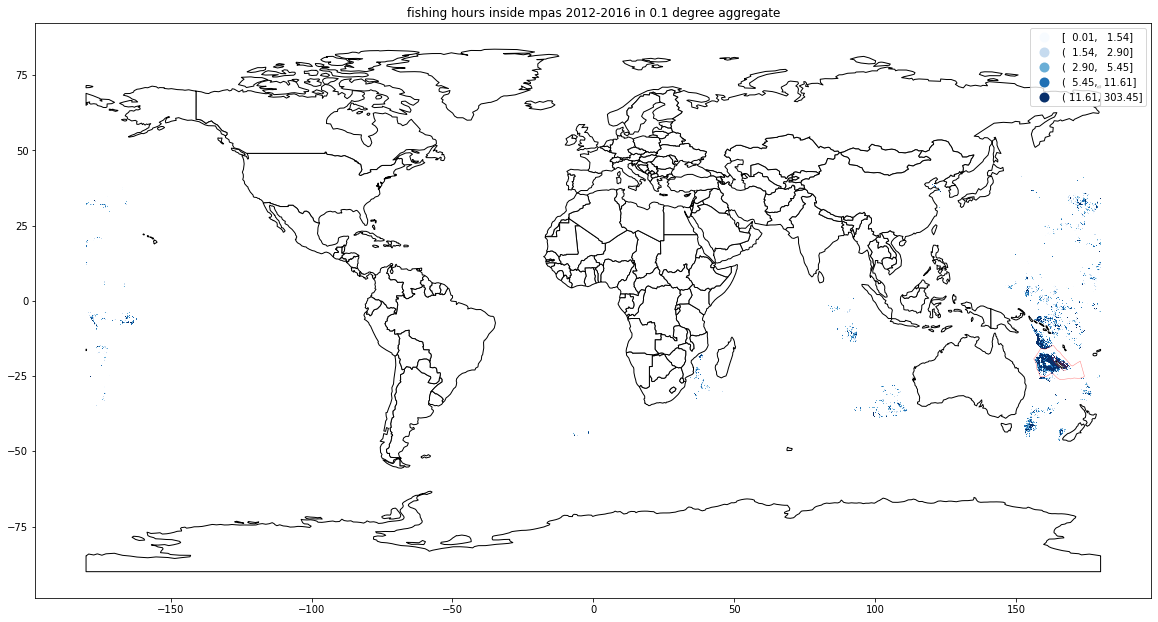

In [25]:
## Park Coral Plot


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='black', figsize=(20, 30))

#ax = park_coral_points.plot(column='fishing_hours', figsize=(20, 30), cmap='Blues', scheme='quantiles', legend=True)

pre.plot(column='fishing_hours', cmap='Blues', scheme='quantiles', ax=ax, legend=True)
#post.plot(column='fishing_hours', cmap='Greens', scheme='quantiles', ax=ax)



LINEWIDTH = 0.5
park_coral.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH, alpha=0.5)

plt.title('all fishing effort by ships that fished in the Natural Park of the Coral Seas, pre closure')

Text(0.5, 1.0, 'fishing hours inside mpas 2012-2016 in 0.1 degree aggregate')

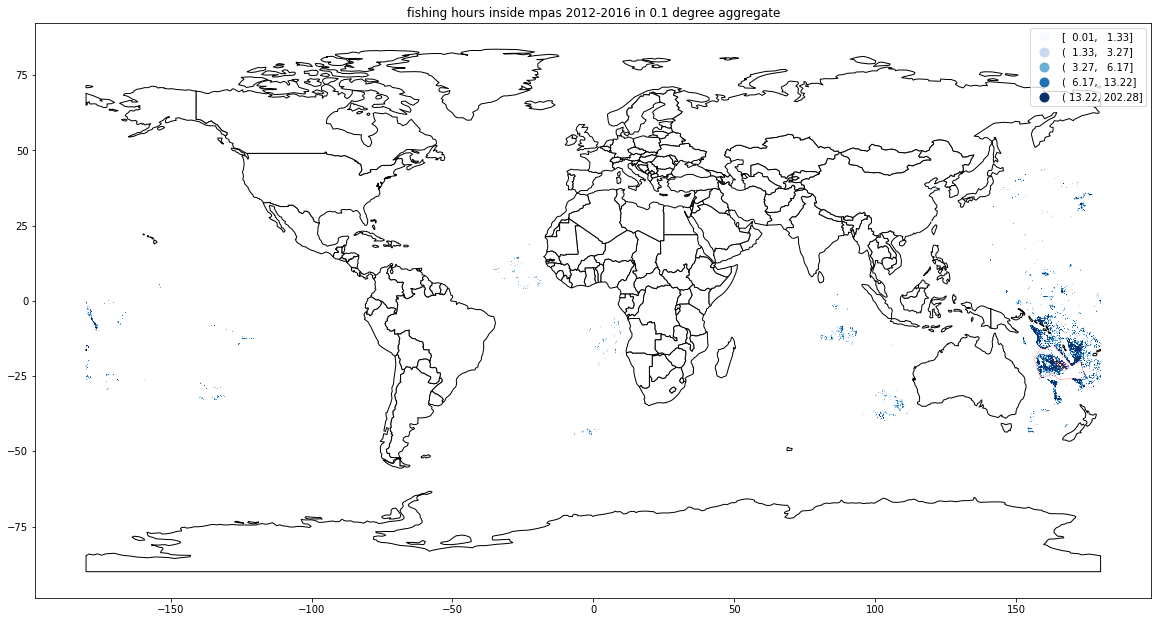

In [24]:
## Park Coral Plot


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='black', figsize=(20, 30))

#ax = park_coral_points.plot(column='fishing_hours', figsize=(20, 30), cmap='Blues', scheme='quantiles', legend=True)

#pre.plot(column='fishing_hours', cmap='Blues', scheme='quantiles', ax=ax)
post.plot(column='fishing_hours', cmap='Blues', scheme='quantiles', ax=ax, legend=True)



LINEWIDTH = 0.5
park_coral.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH, alpha=0.5)

plt.title('fishing hours inside mpas 2012-2016 in 0.1 degree aggregate')

In [ ]:
## Palau analysis
palau = mpas[mpas['WDPAID'] == 555622118.0]

print('running sjoin... ', end='')
palau_points = geopandas.sjoin(geopoints_raw, palau, op='within')
print('done.')
print(palau_points.info())

points_of_palau_ships = geopandas.GeoDataFrame(points_[points_['mmsi'].isin(palau_points['mmsi'])])

In [ ]:
## Plot
ax = palau_points.plot(column='fishing_hours', figsize=(20, 30), cmap='Blues', scheme='quantiles', legend=True)


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.plot(color='white', edgecolor='black', ax=ax, )
points_of_palau_ships.plot(column='fishing_hours', cmap='Reds', scheme='quantiles', ax=ax)

LINEWIDTH = 0.5
palau.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH, alpha=0.5)

plt.title('fishing hours inside mpas 2012-2016 in 0.1 degree aggregate')